In [1]:
import rasterio
import numpy as np
import rioxarray as rioxr

#from shapely.geometry import shape

import matplotlib.pyplot as plt

import geopandas as gpd

from pathlib import Path
from shapely.geometry import shape
from shapely.geometry import box

## OPEN NAIP NIR RASTER

In [2]:
fp = "/home/jovyan/PlanetComp_NAIP2/all_rasters/sb_nir.tif"
nir = rioxr.open_rasterio(fp)
#nir

print('original shape: ', nir.shape)
nir = nir.squeeze()
print('squeezed shape: ', nir.shape)

original shape:  (1, 12320, 10390)
squeezed shape:  (12320, 10390)


In [3]:
#nir.plot()

## OPEN NAIP RGB RASTER

In [4]:
fp = "/home/jovyan/PlanetComp_NAIP2/all_rasters/sb_rgb.tif"
rgb = rioxr.open_rasterio(fp)
#rgb

In [5]:
#rgb.plot.imshow()

## POLYGON FOR CUTING COMPLETE NAIP IMAGE
Obtained the bounding box coordinates from  https://boundingbox.klokantech.com

Select GeoJSON option at the bottom. These are in "EPSG:4326" CRS, so we will have to set tha manually. 

In [6]:
reduce_box = {
    "type": "Polygon",
    "coordinates":[[[-119.706701282,34.4111229027],
                    [-119.6914677414,34.4111229027],
                    [-119.6914677414,34.4281372721],
                    [-119.706701282,34.4281372721],
                    [-119.706701282,34.4111229027]]],
}

reduce_shape = shape(reduce_box)

reduce = gpd.GeoDataFrame()
reduce.loc[0,'geometry']  = reduce_shape
reduce = reduce.set_crs("EPSG:4326")
# MATCH CRES WITH RASTERS
reduce = reduce.to_crs(rgb.rio.crs)
#reduce.crs

In [7]:
# SAVE SHAPE
#outfp = "/home/jovyan/PlanetComp_NAIP2/reduce_polygon.shp"
#reduce.to_file(outfp)
#reduce = gpd.read_file(outfp)

## CLIP NIR NAP IMAGE TO SMALLER REGION

What's up with the star * at the front of `reduce.total_bounds
https://stackoverflow.com/questions/400739/what-does-asterisk-mean-in-python

Documentation for `rio.clip_box`
https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors

In [8]:
nir_small = nir.rio.clip_box(*reduce.total_bounds)
print('original shape: ', nir.shape)
print('reduced shape: ', nir_small.shape)

original shape:  (12320, 10390)
reduced shape:  (3208, 2419)


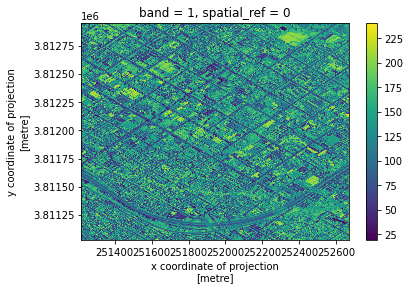

In [9]:
nir_small.plot()

## SAVE NIR NAIP REDUCED IMAGE

In [10]:
nir_reduced_fp = "/home/jovyan/PlanetComp_NAIP2/naip_reduced/nir_reduced2.tif"

with rasterio.open(
    nir_reduced_fp,  # file path
    'w',           # w = write
    driver='GTiff', # format
    height=nir_small.shape[0], 
    width=nir_small.shape[1],
    count=1,  # number of raster bands in the dataset
    dtype=nir_small.dtype,
    crs=nir_small.rio.crs,
    transform=nir_small.rio.transform(),
) as dst:
    dst.write(nir_small.values, 1)
    

nir_check = rioxr.open_rasterio(nir_reduced_fp)
print('original shape:', nir_small.shape)
print('saved shape:', nir_check.shape)
print('saved dtype:',nir_check.dtype)
#nir_check.plot()

original shape: (3208, 2419)
saved shape: (1, 3208, 2419)
saved dtype: uint8


In [11]:
Path(nir_reduced_fp).stat().st_size/1048576

7.407121658325195

## CLIP RGB NAP IMAGE TO SMALLER REGION

original shape:  (3, 12320, 10390)
reduced shape:  (3, 3208, 2419) 

original dtype : uint8
reduced dtype : uint8


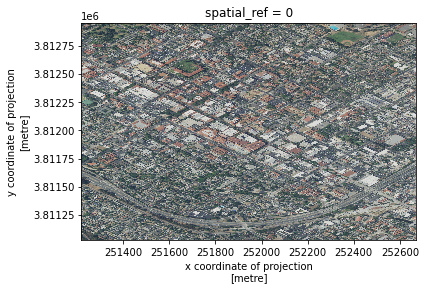

In [12]:
rgb_small = rgb.rio.clip_box(*reduce.total_bounds)
print('original shape: ', rgb.shape)
print('reduced shape: ', rgb_small.shape, '\n')
print('original dtype :', rgb.dtype)
print('reduced dtype :', rgb_small.dtype)
rgb_small.plot.imshow()

## SAVE RGB NAIP REDUCED IMAGE

In [13]:
rgb_small_fp = "/home/jovyan/PlanetComp_NAIP2/naip_reduced/rgb_reduced2.tif"

with rasterio.open(
    rgb_small_fp,
    'w',
    driver='GTiff',
    height=rgb_small.shape[1],
    width=rgb_small.shape[2],
    count=3,  # number of raster bands in the dataset
    dtype=rgb_small.dtype,
    crs=rgb_small.rio.crs,
    transform=rgb_small.rio.transform(),
) as dst:
    dst.write(rgb_small.values, [1,2,3])

rgb_check = rioxr.open_rasterio(rgb_small_fp)
print('original shape:', rgb_small.shape)
print('saved shape:', rgb_check.shape)
print('saved dtype:',rgb_check.dtype)

#rgb_check.plot.imshow()

original shape: (3, 3208, 2419)
saved shape: (3, 3208, 2419)
saved dtype: uint8


In [14]:
Path(rgb_small_fp).stat().st_size/1048576

22.22068214416504

## NCEAS AOI

In [38]:
aoi_box = {
    "type": "Polygon",
    "coordinates":[[[-119.7062718629,34.4222115638],
                    [-119.6951987997,34.4222115638],
                    [-119.6951987997,34.4276811896],
                    [-119.7062718629,34.4276811896],
                    [-119.7062718629,34.4222115638]]],
}

aoi_shape = shape(aoi_box)

aoi = gpd.GeoDataFrame()
aoi.loc[0,'geometry']  = aoi_shape
aoi = aoi.set_crs("EPSG:4326")
aoi_match = aoi.to_crs(rgb.rio.crs)
#aoi

<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

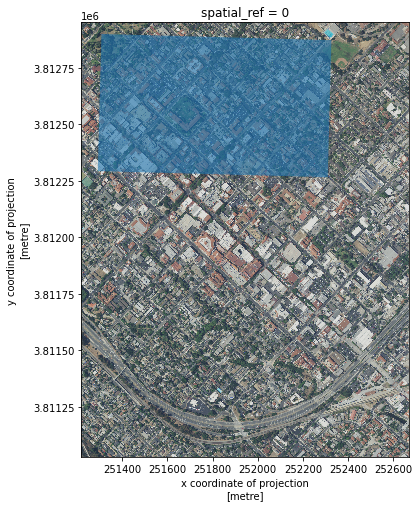

In [39]:
bounds = box(*aoi.total_bounds)
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
rgb_small.plot.imshow(ax=ax)
aoi_match.plot(ax=ax, alpha=0.6)

## SAVE AOI SHAPEFILE WITH ORIGINAL CRS

In [40]:
# SAVE SHAPE
outfp = "/home/jovyan/PlanetComp_NAIP2/nceas_aoi/nceas_aoi.shp"
aoi.to_file(outfp)
aoi_check = gpd.read_file(outfp)
aoi_check

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,FID,geometry
0,0,"POLYGON ((-119.70627 34.42221, -119.70627 34.4..."


In [41]:
print(aoi_check.crs)

epsg:4326


### OTHER MATERIAL

https://www.neonscience.org/resources/learning-hub/tutorials/neon-hsi-aop-functions-python

**How to run binder**
https://www.youtube.com/watch?v=owSGVOov9pQ
https://github.com/rasbt/watermark

## 

In [ ]:
# new_aoi_box = {
#     "type": "Polygon",
#     "coordinates":[[[251291.66073254717, 3812293.568482157],
#                     [252309.55190149156, 3812293.568482157],
#                     [252309.55190149156, 3812873.1708947034],
#                     [251291.66073254717, 3812873.1708947034],
#                     [251291.66073254717, 3812293.568482157]]],
# }

In [13]:
rgb_clip = rgb.rio.clip_box(*aoi.total_bounds)
print(rgb_clip.shape)

(3, 1549, 2204)


In [14]:
nir_clip = nir.rio.clip_box(*aoi.total_bounds)
print(nir_clip.shape)

(1, 1549, 2204)


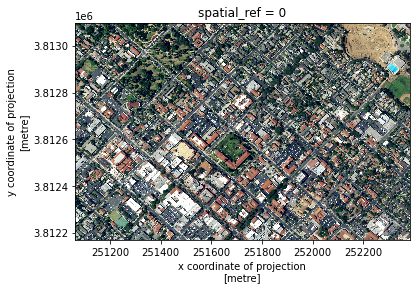

In [17]:
rgb_clip.plot.imshow(robust=True)

In [57]:
rgb_clip_fp = "/home/jovyan/PlanetComp_NAIP2/clip_rgb.tif"

with rasterio.open(
    rgb_clip_fp,
    'w',
    driver='GTiff',
    height=rgb_clip.shape[1],
    width=rgb_clip.shape[2],
    count=3,  # number of raster bands in the dataset
    dtype='int8',
    crs=rgb_clip.rio.crs,
    transform=rgb_clip.rio.transform(),
) as dst:
    dst.write(rgb_clip.values, [1,2,3])

## NDVI

In [18]:
red_clip = rgb_clip.sel(band=1)
red_clip

<xarray.DataArray (y: 1549, x: 2204)>
array([[ 50,  48,  57, ..., 142, 127,  88],
       [ 49,  60,  52, ..., 134, 145, 135],
       [ 53,  62,  47, ..., 125, 134, 150],
       ...,
       [113, 102,  98, ..., 219, 219, 215],
       [119, 115,  94, ..., 216, 214, 198],
       [121, 118, 102, ..., 212, 195, 182]], dtype=uint8)
Coordinates:
    band         int64 1
  * x            (x) float64 2.511e+05 2.511e+05 ... 2.524e+05 2.524e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [19]:
ndvi = (nir_clip-red_clip)/(nir_clip+red_clip)

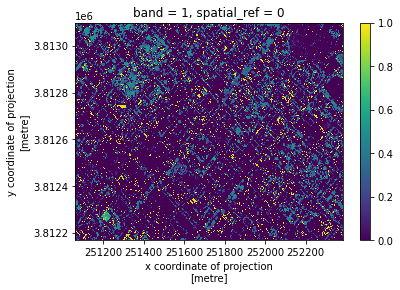

In [21]:
ndvi.plot()

In [22]:
# trial = ndvi.to_numpy()
# trial[np.where(trial>1)] = 0
# plt.imshow(trial)

## CHANGE DATA TYPE

In [23]:
red16 = red_clip.astype('int16')
nir16 = nir_clip.astype('int16')
print('red dtype: ', red_clip.dtype, 'red16 dtype :', red16.dtype)
print('nir dtype: ', nir_clip.dtype, 'nir16 dtype :', nir16.dtype)

red dtype:  uint8 red16 dtype : int16
nir dtype:  uint8 nir16 dtype : int16


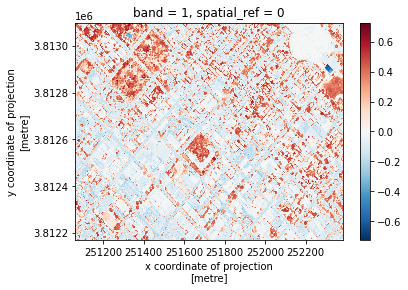

In [24]:
ndvi16 = (nir16 - red16)/(nir16+red16)
ndvi16.plot()

## CLIPPING NAIP IMAGE

In [5]:
small_area = {
    "type": "Polygon",
    "coordinates": [[
        [-119.7153749406,34.4007595382],
        [-119.667382988,34.4007595382],
        [-119.667382988,34.4327498739],
        [-119.7153749406,34.4327498739],
        [-119.7153749406,34.4007595382]]],
}
small_area_shape = shape(small_area)
df2 = gpd.GeoDataFrame()
df2.loc[0,'geometry']  = small_area_shape
df2 = df2.set_crs("EPSG:4326")
df2 = df2.to_crs(rgb.rio.crs)

NameError: name 'shape' is not defined

In [29]:
rgb_small = rgb.rio.clip_box(*df2.total_bounds)
print('original shape: ', rgb.shape)
print('reduced shape: ', rgb_small.shape)

origina shape:  (3, 12320, 10390)
reduced shape:  (3, 6111, 4702)


<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

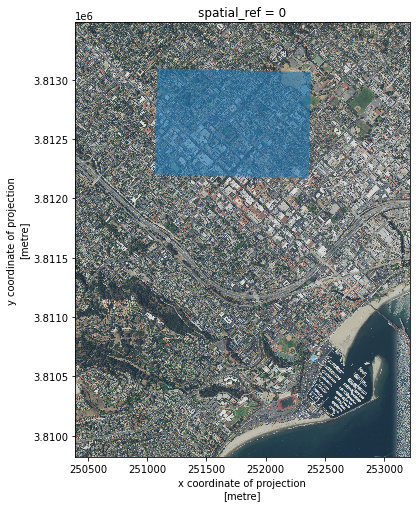

In [60]:
#bounds = box(*df.total_bounds)
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
rgb_small.plot.imshow(ax=ax)
df.plot(ax=ax, alpha=0.6)

In [42]:
nir_small = nir.rio.clip_box(*df2.total_bounds)
nir_small.shape
print('original shape: ', nir.shape)
print('reduced shape: ', nir_small.shape)

original shape:  (12320, 10390)
reduced shape:  (6111, 4702)


<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

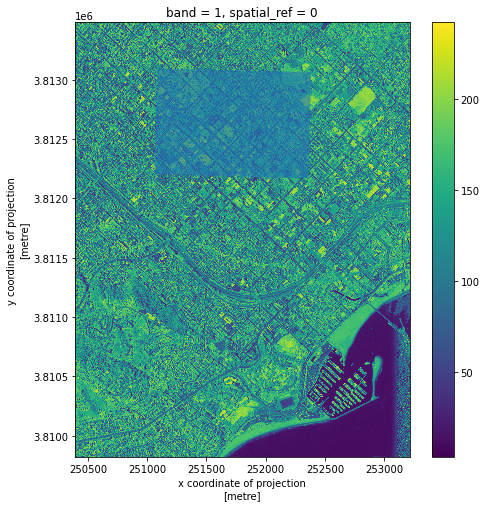

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
nir_small.plot.imshow(ax=ax)
df.plot(ax=ax, alpha=0.6)

## SAVING CLIPPED RASTERS

In [67]:
nir_small_fp = "/home/jovyan/PlanetComp_NAIP2/small_nir16.tif"

with rasterio.open(
    nir_small_fp,  # file path
    'w',           # w = write
    driver='GTiff', # format
    height=nir_small.shape[0], 
    width=nir_small.shape[1],
    count=1,  # number of raster bands in the dataset
    dtype='int16',
    crs=nir_small.rio.crs,
    transform=nir_small.rio.transform(),
) as dst:
    dst.write(nir_small.values, 1)
    

nir_check = rioxr.open_rasterio(nir_small_fp)
#print(nir_check.shape)
#nir_check.plot()

In [71]:
nir_small.dtype
rgb_check = rioxr.open_rasterio(rgb_small_fp)

int16


(3, 6111, 4702)
int16


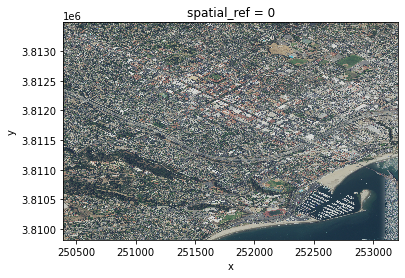

In [62]:
rgb_small_fp = "/home/jovyan/PlanetComp_NAIP2/small_rgb16.tif"

with rasterio.open(
    rgb_small_fp,
    'w',
    driver='GTiff',
    height=rgb_small.shape[1],
    width=rgb_small.shape[2],
    count=3,  # number of raster bands in the dataset
    dtype='int16',
    crs=rgb_small.rio.crs,
    transform=rgb_small.rio.transform(),
) as dst:
    dst.write(rgb_small.values, [1,2,3])

rgb_check = rioxr.open_rasterio(rgb_small_fp)
print(rgb_check.shape)
print(rgb_check.dtype)

rgb_check.plot.imshow()

In [47]:
nir2 = nir_check.rio.clip_box(*df.total_bounds)
red2 = rgb_check.sel(band=1).rio.clip_box(*df.total_bounds)

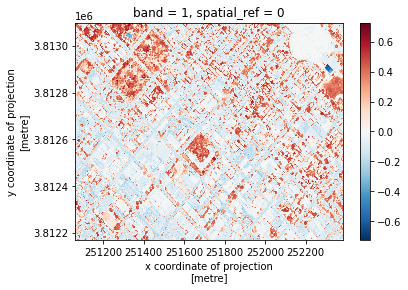

In [48]:
ndvi2 = (nir2-red2)/(nir2+red2)
ndvi2.plot()